In [18]:
using Optim, OptimTestProblems
OptimTestProblems.UnconstrainedProblems.examples["Rosenbrock"]
# These codes turn f and g into one function ... 
function opt_combine(x, f, g!)
    g = Array{Float64,1}(undef,length(x))
    g!(g,x)
    return (f(x), g)
end
function opt_problem(p::OptimTestProblems.UnconstrainedProblems.OptimizationProblem)
    return x -> opt_combine(x, p.f, p.g!)
end
# this just makes it easy to use
opt_problem(s::AbstractString) = opt_problem(
    OptimTestProblems.UnconstrainedProblems.examples[s])

# Here's an example 
fg = opt_problem("Himmelblau")
f, g = fg([0.0,0.0]) # show the function and gradient

(170.0, [-14.0, -22.0])

In [2]:
problems = keys(OptimTestProblems.UnconstrainedProblems.examples)

KeySet for a Dict{AbstractString, OptimTestProblems.MultivariateProblems.OptimizationProblem} with 17 entries. Keys:
  "Rosenbrock"
  "Quadratic Diagonal"
  "Hosaki"
  "Large Polynomial"
  "Penalty Function I"
  "Beale"
  "Extended Rosenbrock"
  "Polynomial"
  "Powell"
  "Exponential"
  "Paraboloid Diagonal"
  "Paraboloid Random Matrix"
  "Extended Powell"
  "Trigonometric"
  "Fletcher-Powell"
  "Parabola"
  "Himmelblau"

In [4]:
using Pkg; Pkg.add(["IterTools"])

    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [c8e1da08] + IterTools v1.4.0
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


(r1, r[end]) = (0.0, 0.1961961961961962)
(r1, r[end]) = (0.1971971971971972, 0.8308308308308309)
(r1, r[end]) = (0.8318318318318318, 1.0)


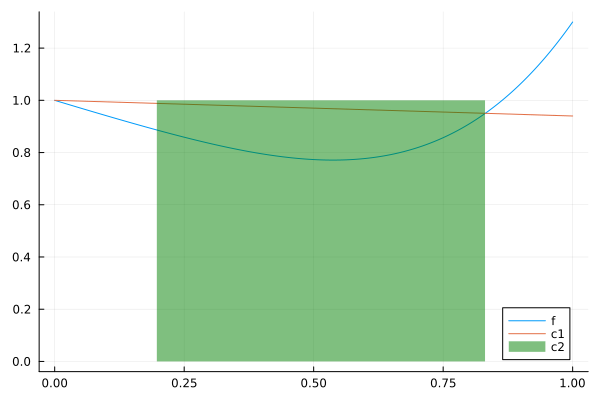

In [20]:
using Plots, LinearAlgebra, IterTools

"""
Make a line search plot that shows what the function
looks like in a direction p, with regions for the
strong Wolfe conditions satisfied. 
"""
function line_search_plot(fg, x, p; amax=1.0, c2 = 0.90, c1 = 0.1, npts=1000, strong=false)
    agrid = range(0,stop=amax,length=npts)
    fvals = map(a -> fg(x + a*p)[1], agrid) # generate function values
    plt = plot(agrid, fvals, label="f")
    
    g0 = dot(fg(x)[2],p)
    f0 = fg(x)[1]
    
    plot!([agrid[1], agrid[end]],[f0,f0+c1*g0*agrid[end]],label="c1")
        
    gvals = map(a -> abs(dot(fg(x+a*p)[2],p)), agrid)
    
    if strong
        validwolfe = a -> (abs(dot(fg(x+a*p)[2],p)) <= c2*abs(g0)) * 
                          (fg(x + a*p)[1] <= f0+c1*g0*a)
    else
        validwolfe = a -> (dot(fg(x+a*p)[2],p) >= c2*g0) * 
                          (fg(x + a*p)[1] <= f0+c1*g0*a)
    end
    
    
    regions = groupby(validwolfe, agrid)
    for r in regions
        r1 = r[1]
        @show r1, r[end]
        
        if validwolfe(r1)
            plot!([r[1],r[end]], [f0, f0],fill=(0,:green,0.5),line=(0),label="c2")
        end
    end
   
    return plt
end
fg = opt_problem("Rosenbrock")
x = [0.0,0.0]
p = [0.3,0.0]
line_search_plot(fg, x, p; strong=false)

(r1, r[end]) = (0.0, 0.003003003003003003)
(r1, r[end]) = (0.004004004004004004, 0.8638638638638638)
(r1, r[end]) = (0.8648648648648649, 1.0)


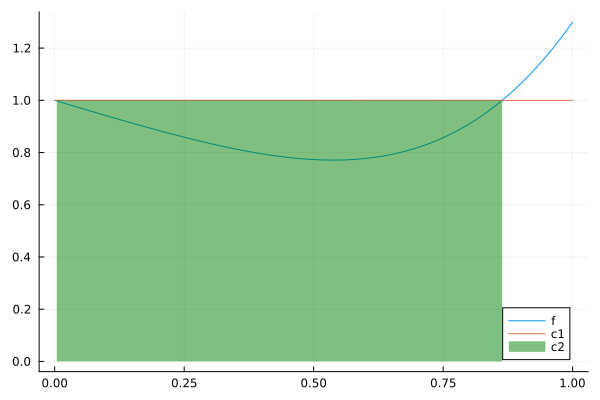

In [21]:
fg = opt_problem("Rosenbrock")
x = [0.0,0.0]
p = [0.3,0.0]
line_search_plot(fg, x, p; strong=false, c1 = 0.0001, c2 = 0.999)

(r1, r[end]) = (0.0, 0.5425425425425425)
(r1, r[end]) = (0.5435435435435435, 0.5865865865865866)
(r1, r[end]) = (0.5875875875875876, 1.0)


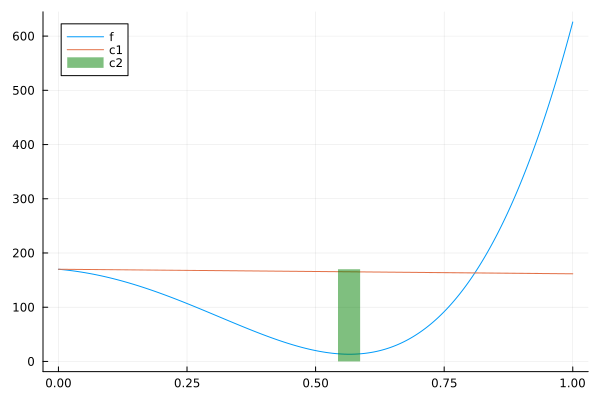

In [25]:
fg = opt_problem("Himmelblau")
x = [0.0,0.0]
p = [6.0,0.0]
line_search_plot(fg, x, p; strong=true, amax=1)

(r1, r[end]) = (0.0, 0.11261261261261261)
(r1, r[end]) = (0.11311311311311312, 0.13813813813813813)
(r1, r[end]) = (0.13863863863863865, 0.5)


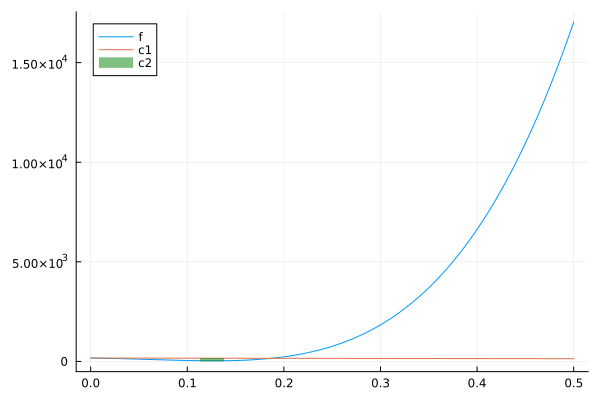

In [27]:
fg = opt_problem("Himmelblau")
x = [0.0,0.0]
p = - fg(x)[2]
line_search_plot(fg, x, p; strong=true, amax=0.5)

(r1, r[end]) = (0.0, 3.2372372372372373)
(r1, r[end]) = (3.2432432432432434, 3.5315315315315314)
(r1, r[end]) = (3.5375375375375375, 6.0)


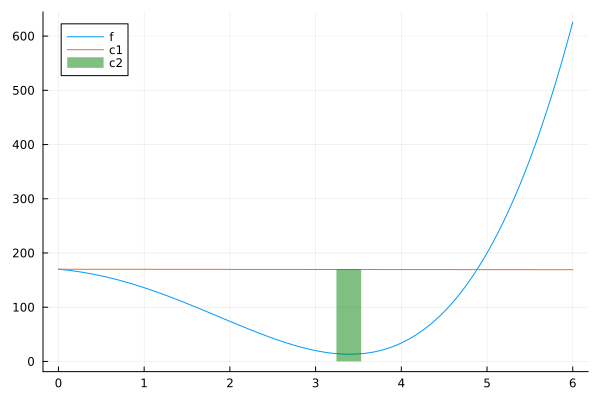

In [32]:
fg = opt_problem("Himmelblau")
x = [0.0,0.0]
p = [1.0,0.0]
line_search_plot(fg, x, p; strong=true, amax=6, c1=0.01, c2=0.999999)

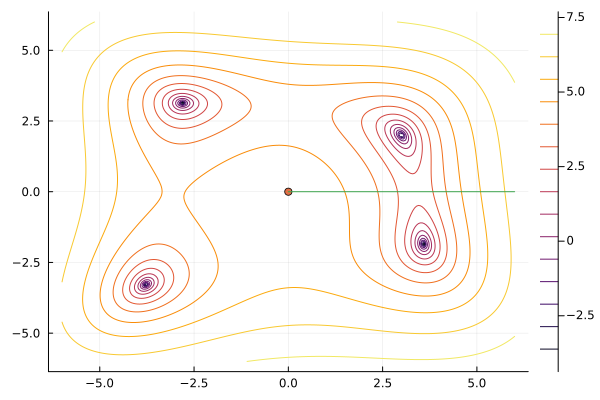

In [8]:
using Plots

ezcontour(x, y, f) = begin
    X = repeat(x', length(y), 1)
    Y = repeat(y, 1, length(x))
    # Evaluate each f(x, y)
    Z = map((x,y) -> log(f([x,y])), X, Y)
    plot(x, y, Z, st=:contour)
end

function line_search_contour(fg, x, y, xk, p; amax=1.0)
    ezcontour(x, y, z -> fg(z)[1])
    scatter!([xk[1]],[xk[2]],label="")
    plot!([xk[1], xk[1] + amax*p[1]], [xk[2], xk[2] + amax*p[2]], label="")
end

line_search_contour(fg, -6:0.05:6, -6:0.05:6, x, p; amax=6.0)

In [7]:
# TODO - make an interact module that allows you to vary distances in a 2d region and look at line searches! 